In [1]:
import pandas as pd
import numpy as np
import os as os
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Pick up the date we grabbed in our acquisition. Don't really need to rebalance often, so it doesn't make sense to pull via sdk and 
# waste the message count of whatever service we use. 

file_path = Path('../FinTech-Project-2/sp500_close.csv')

sp500_close = pd.read_csv(file_path,
                         parse_dates=True,
                         index_col = 'date',
                         infer_datetime_format=True)
sp500_close.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 00:00:00+00:00,207.49,78.59,80.10,348.06,164.20,42.84,264.01,23.68,160.62,17.50,...,172.56,125.12,54.92,31.29,126.64,76.37,95.37,125.41,51.17,95.75
2019-03-04 00:00:00+00:00,206.86,78.62,79.46,338.20,162.82,41.79,258.16,23.37,158.40,17.12,...,173.05,125.57,55.08,31.36,122.81,76.25,95.14,124.43,50.86,95.87
2019-03-05 00:00:00+00:00,203.84,78.22,78.91,333.21,163.67,41.88,257.38,23.50,157.31,17.42,...,182.04,124.14,54.90,31.09,122.95,76.19,95.93,124.11,50.79,95.78
2019-03-06 00:00:00+00:00,202.80,77.70,78.09,317.85,162.39,42.56,256.40,22.41,157.97,17.58,...,170.88,123.55,55.09,30.85,121.36,75.85,96.60,123.24,49.67,94.17
2019-03-07 00:00:00+00:00,199.86,76.80,78.24,317.42,161.85,41.42,255.46,22.08,154.13,17.67,...,170.20,118.67,55.52,30.24,119.91,75.32,96.54,121.39,48.71,92.55


In [3]:
#sp500_full['symbol'].unique()

## Overall Approach
1. Identify the investable universe. For this data sample, we chose the S&P500 of 2019. 
2. Create the Generic Momentum Screen. We rank firms within our universe based on their past 12-month returns, ignoring the last month. 
3. Momentum Quality Screen: WE screen high-mom firms on the quality of the mom, which is measured by the FIP algorithm. (detailed below)
4. Momentum Seasonality Screen: take advantage of the seasonal aspects applicable to MoM investing, which determines the timing of the rebalance. We rebalance quarterly before quarter ending months. 
5. Invest with conviction: We invest in a concentrated portfolo of stocks with teh highest quality momentum. 

A hypothetical portfolio construction scenario would work in the following way. Consider a universe of 1,000 stocks identified in step 1. In step 2, we calculate generic momentum scores for each of the 1,000 securities and identify the top 10 percent, or 100 highest generic momentum stocks. For step 3, we calculate the FIP score for the 100 high-momentum names identified in step 2 and rank these 100 stocks on FIP, where lower is better. We identify the top half, or 50 high-momentum stocks with the smoothest momentum. In step 4, we determine the model portfolio and conduct our rebalance at the end of February, May, August, and November to exploit seasonality effects. Finally, in step 5, we implement the roughly 50-stock portfolio strategy with an equal-weight construction (to minimize stock specific risk) and prepare for high relative performance volatility and the blessing (and curse) of long periods of relative outperformance (and underperformance). 

Gray, Wesley R.; Vogel, Jack R.. Quantitative Momentum: A Practitioner's Guide to Building a Momentum-Based Stock Selection System (Wiley Finance) (Kindle Locations 3617-3623). 

## Generic Momentum Screen

In this step, we will apply the generic momentum screen on monthly returns calculated from daily returns, removing the last month. 

In [4]:
mid=sp500_close[:-21]

In [5]:
short=sp500_close[-21:]

In [6]:
overall_returns_mid=mid.pct_change()
cum_returns_mid=((1+overall_returns_mid).cumprod()-1).iloc[[-1]]

overall_returns_short=short.pct_change()
cum_returns_short=((1+overall_returns_short).cumprod()-1).iloc[[-1]]

## Generic Momentum

In [7]:
#Begin the process of moving the horizontal dataframe back to a vertical dataframe. 
return_list_mid = cum_returns_mid.stack()
return_list_short = cum_returns_short.stack()
return_list_mid

date                           
2020-01-29 00:00:00+00:00  MMM    -0.219239
                           ABT     0.134241
                           ABBV    0.038702
                           ABMD   -0.457421
                           ACN     0.266504
                                     ...   
                           XYL     0.089040
                           YUM     0.118066
                           ZBH     0.202057
                           ZION   -0.093805
                           ZTS     0.446580
Length: 503, dtype: float64

In [8]:
df_mid = return_list_mid.to_frame().reset_index()
df_short = return_list_short.to_frame().reset_index()
df_mid.head()

,date,level_1,0
0,2020-01-29 00:00:00+00:00,MMM,-0.219239
1,2020-01-29 00:00:00+00:00,ABT,0.134241
2,2020-01-29 00:00:00+00:00,ABBV,0.038702
3,2020-01-29 00:00:00+00:00,ABMD,-0.457421
4,2020-01-29 00:00:00+00:00,ACN,0.266504


In [9]:
df_mid.rename(columns ={0:"return","level_1":"symbol"}, inplace = True)
df_short.rename(columns ={0:"return","level_1":"symbol"}, inplace = True)

In [10]:
df_mid.drop(columns=['date'], inplace=True)
df_short.drop(columns=['date'], inplace=True)

In [11]:
df_mid.set_index(df_mid['symbol'], inplace = True)
df_short.set_index(df_short['symbol'], inplace = True)

In [12]:
df_mid.drop(columns=['symbol'], inplace=True)
df_short.drop(columns=['symbol'], inplace=True)

In [13]:
df_mid.sort_values(['return'],ascending=False,inplace=True)
df_short.sort_values(['return'],ascending=False,inplace=True)

In [14]:
df_mid['decile_rank']=pd.qcut(df_mid['return'],10,labels=False)
df_short['decile_rank']=pd.qcut(df_short['return'],10,labels=False)

In [15]:
df_mid.sort_values(['decile_rank'],ascending=False,inplace=True)
top_decile_mid=df_mid.loc[df_mid['decile_rank']==9]

df_short.sort_values(['decile_rank'],ascending=False,inplace=True)
top_decile_short=df_short.loc[df_short['decile_rank']==9]

In [16]:
top_decile_mid

,return,decile_rank
symbol,,
AMD,1.006334,9
SPGI,0.472998,9
DVA,0.456266,9
MKTX,0.448188,9
ZTS,0.446580,9
LEN,0.441208,9
SWKS,0.438034,9
CMG,0.437634,9
ALLE,0.434430,9


In [17]:
top_decile_short

,return,decile_rank
symbol,,
REGN,0.322417,9
LH,-0.018711,9
CAH,-0.021955,9
J,-0.022754,9
CTSH,-0.024652,9
COG,-0.026555,9
IPGP,-0.026615,9
SJM,-0.026744,9
AJG,-0.027046,9


## FIP = sign(Past return) * [% negative - % positive]

In [18]:
#Cam - before we do this step we need to (1) bin and take the top decile. Need to drop the date, bin, and then determine the tickers
# that have the top returns. Then we need to take those returns and come back through this process. 

# The signal here is that we need to remove "low quality" momentum. Stocks that "pop" are shown to be overpriced and generally under-
# perform. The underperformance is the result of mispricing caused by biased investors whom overpay for lottery-like stocks. 

# The more negative the FIP, the better. We are seperating high momentum stocks into those that have more continuous price paths. 
    # If FIP scores are positive, then automatically the security had poor returns over the last year (it was a negative number). 
    # If FIP is a little negative, it had positive returns, but a bumpy ride. 
    # If FIP is very negative, then smoother path, which reflects the behavioral irrational decision making of "lack of attention". 
    # The lack of attention is the best momentum, where these securities are more likely to suffer from why momentum stocks outperform:
    # investors are systematically underreacting to positive news. 

fip_scores_mid = []
for column in overall_returns_mid.columns:
    num_positive_mid = len(overall_returns_mid.loc[overall_returns_mid[column] > 0])
    num_negative_mid = len(overall_returns_mid.loc[overall_returns_mid[column] < 0])
    num_zero_mid = len(overall_returns_mid.loc[overall_returns_mid[column] == 0])
    num_days_mid = len(overall_returns_mid)
    cum_returns_mid = overall_returns_mid[column].sum() # this will be deprecated to calculate Generic Momentum, which will be past year minus
                                                # most recent month. 
    
    fip_score_mid = np.sign(cum_returns_mid) * (num_negative_mid / num_days_mid - num_positive_mid/num_days_mid)
    
    fip_scores_mid.append(fip_score_mid)
    
fip_scores_short = []
for column in overall_returns_short.columns:
    num_positive_short = len(overall_returns_short.loc[overall_returns_short[column] > 0])
    num_negative_short = len(overall_returns_short.loc[overall_returns_short[column] < 0])
    num_zero_short = len(overall_returns_short.loc[overall_returns_short[column] == 0])
    num_days_short = len(overall_returns_short)
    cum_returns_short = overall_returns_short[column].sum() # this will be deprecated to calculate Generic Momentum, which will be past year minus
                                                # most recent month. 
    
    fip_score_short = np.sign(cum_returns_short) * (num_negative_short / num_days_short - num_positive_short/num_days_short)
    
    fip_scores_short.append(fip_score_short)

In [19]:
# we need to get tie the fip scores to the index of tickers, and sort the fip scores

In [20]:
# for i, column in enumerate(overall_returns.columns):
#     print(f"{column}, fip_score: {fip_scores[i]}")

In [21]:
# overall_returns

In [22]:
fip_scores_series_mid = pd.Series(fip_scores_mid, index = overall_returns_mid.columns)
fip_scores_series_mid.name = "fip_scores_mid"

fip_scores_series_short = pd.Series(fip_scores_short, index = overall_returns_short.columns)
fip_scores_series_short.name = "fip_scores_short"

In [23]:
fip_scores_series_mid

MMM    -0.043290
ABT    -0.125541
ABBV   -0.043290
ABMD    0.021645
ACN    -0.129870
          ...   
XYL    -0.056277
YUM    -0.086580
ZBH    -0.051948
ZION    0.082251
ZTS    -0.155844
Name: fip_scores_mid, Length: 503, dtype: float64

In [24]:
import plotly.express as px
import seaborn as sns

In [26]:
x_mid = top_decile_mid.merge(fip_scores_series_mid, right_index = True, left_index = True).sort_values(by = 'fip_scores_mid', ascending = True)[:50]
x_short = top_decile_short.merge(fip_scores_series_short, right_index = True, left_index = True).sort_values(by = 'fip_scores_short', ascending = True)[:50]

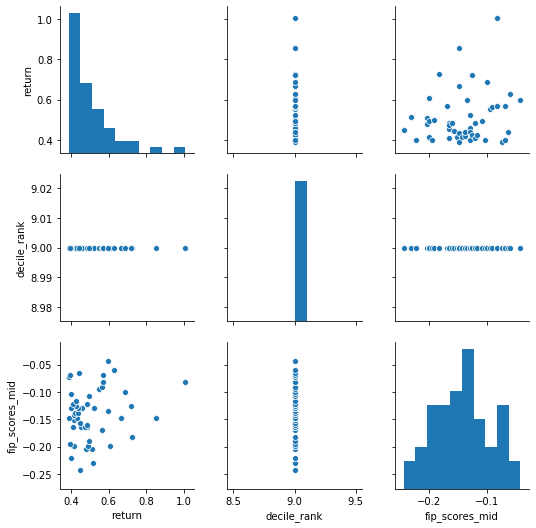

In [27]:
sns.pairplot(x_mid)

In [28]:
x_mid

,return,decile_rank,fip_scores_mid
MKTX,0.448188,9,-0.242424
GPN,0.515476,9,-0.229437
SO,0.402561,9,-0.220779
WU,0.510708,9,-0.203463
INFO,0.478140,9,-0.203463
MSFT,0.493291,9,-0.199134
RMD,0.608379,9,-0.199134
MA,0.409549,9,-0.199134
NEE,0.416933,9,-0.199134
EFX,0.397972,9,-0.194805


In [29]:
x_short

,return,decile_rank,fip_scores_short
REGN,0.322417,9,-0.476190
AAP,-0.016929,9,-0.285714
CLX,0.022841,9,-0.285714
MSCI,0.009120,9,-0.190476
ZTS,-0.034775,9,-0.190476
NVDA,0.098694,9,-0.190476
ABBV,0.048056,9,-0.190476
TIF,-0.003655,9,-0.142857
DE,-0.028738,9,-0.095238
CL,-0.027350,9,-0.095238


In [30]:
mid_stocks=pd.DataFrame()
for i in sp500_close.columns:
    if i in x_mid.index:
        mid_stocks[i]=sp500_close[i]
        

In [31]:
short_stocks=pd.DataFrame()
for i in sp500_close.columns:
    if i in x_short.index:
        short_stocks[i]=sp500_close[i]

In [34]:
mid_stocks.to_csv('../FinTech-Project-2/sp500_mom_mid.csv')
short_stocks.to_csv('../FinTech-Project-2/sp500_mom_short.csv')